In [30]:
%matplotlib widget

In [31]:
from qiskit import QuantumCircuit
from weylchamber import c1c2c3, WeylChamber
from qiskit.quantum_info import Operator
import numpy as np
from qiskit import transpile

In [32]:
# observable = SparsePauliOp("XZ")
# qubits = observable.num_qubits
# ansatz = RealAmplitudes(observable.num_qubits, reps=3)
# display(ansatz.decompose().draw('mpl'))
# backend = service.get_backend('ibm_lagos')
# transpiled_ansatz = transpile(ansatz, backend=backend,
#                               basis_gates=['u1', 'u2', 'u3', 'rx', 'ry', 'rz', 'cx', 'cz'],
#                               seed_transpiler=42,
#                               optimization_level=3)
# display(transpiled_ansatz.decompose().draw('mpl'))

In [33]:
# from qiskit.circuit.random import random_circuit
# from qiskit.quantum_info import SparsePauliOp
# from qiskit.circuit.library import RealAmplitudes
# from qiskit_ibm_runtime import QiskitRuntimeService, Session, Estimator, Options

# observable = SparsePauliOp("XZ")
# qubits = observable.num_qubits
# ansatz = RealAmplitudes(observable.num_qubits, reps=3)
# display(ansatz.decompose().draw('mpl'))
# backend = service.get_backend('simulator_statevector')
# transpiled_ansatz = transpile(ansatz, backend=backend,
#                               basis_gates=['u1', 'u2', 'u3', 'rx', 'ry', 'rz', 'cx', 'cz'],
#                               seed_transpiler=42,
#                               optimization_level=3)

# service = QiskitRuntimeService()
# with Session(service=service, backend="ibmq_qasm_simulator") as session:
#      estimator = Estimator(session=session, options=options)
#      job = estimator.run(circuit, observable)
#      result = job.result()
#      # Close the session only if all jobs are finished, and you don't need to run more in the session
#      session.close() # Closes the session

# display(circuit.draw("mpl"))
# print(f" > Observable: {observable.paulis}")
# print(f" > Expectation value: {result.values[0]}")
# print(f" > Metadata: {result.metadata[0]}")

In [34]:
qc = QuantumCircuit(2)
qc.cx(0, 1)
print(qc.draw("latex_source"))

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.8em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \ctrl{1} & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \targ & \qw & \qw\\
\\ }}
\end{document}


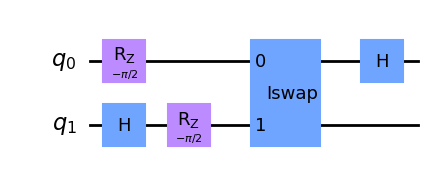

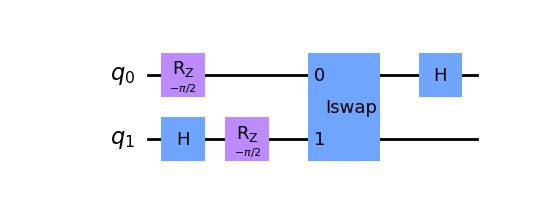

In [35]:
from virtual_swap.cns_transform import cx_replace

# cx_replace.swap(0, 1)
cx_replace.draw("mpl")

In [36]:
Operator(cx_replace_swap).equiv(qc)

NameError: name 'cx_replace_swap' is not defined

In [ ]:
qc = QuantumCircuit(2)
qc.crz(np.pi / 2, 0, 1)
qc = transpile(qc, basis_gates=["u", "cx"])
qc.draw()

q_0: ────────────────■───────────────────■──
     ┌────────────┐┌─┴─┐┌─────────────┐┌─┴─┐
q_1: ┤ U(0,0,π/4) ├┤ X ├┤ U(0,0,-π/4) ├┤ X ├
     └────────────┘└───┘└─────────────┘└───┘

In [ ]:
# replace the last cx gate with iswap+virtual_swap
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.circuit.library import CXGate

dag = circuit_to_dag(qc)
cx_node = dag.op_nodes(CXGate)[1]
from virtual_swap.cns_transform import cns_transform

qc2 = dag_to_circuit(cns_transform(dag, cx_node))
qc2.decompose().draw()

┌──────────┐                  ┌────────┐┌───┐
q_0: ────────────────■────┤ Rz(-π/2) ├──────────────────┤0       ├┤ H ├
     ┌────────────┐┌─┴─┐┌─┴──────────┴┐┌───┐┌──────────┐│  Iswap │└───┘
q_1: ┤ U(0,0,π/4) ├┤ X ├┤ U(0,0,-π/4) ├┤ H ├┤ Rz(-π/2) ├┤1       ├─────
     └────────────┘└───┘└─────────────┘└───┘└──────────┘└────────┘

In [ ]:
Operator(qc2).equiv(qc)

False

In [ ]:
from slam.utils.transpiler_pass.weyl_decompose import RootiSwapWeylDecomposition
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import ConsolidateBlocks, Collect2qBlocks, Unroller

pm = PassManager()
pm.append(Unroller(["u", "cx", "iswap"]))
pm.append(Collect2qBlocks())
pm.append(ConsolidateBlocks(force_consolidate=True))
pm.append(RootiSwapWeylDecomposition())
pm.run(qc2).draw()

global phase: 5.562
      ┌───────────────┐ ┌──────────────┐┌────────────────────────────┐»
q_0: ─┤ U3(π/2,0,π/2) ├─┤0             ├┤ U3(2.5516,-4.3219,0.87313) ├»
     ┌┴───────────────┴┐│  Riswap(0.5) │└───┬───────────────────┬────┘»
q_1: ┤ U3(π/2,0,-3π/2) ├┤1             ├────┤ U3(π/2,0.85165,π) ├─────»
     └─────────────────┘└──────────────┘    └───────────────────┘     »
«     ┌──────────────┐ ┌─────────────────────┐ ┌──────────────┐»
«q_0: ┤0             ├─┤ U3(1.9979,-π/2,π/2) ├─┤0             ├»
«     │  Riswap(0.5) │┌┴─────────────────────┴┐│  Riswap(0.5) │»
«q_1: ┤1             ├┤ U3(0,0.57186,0.57186) ├┤1             ├»
«     └──────────────┘└───────────────────────┘└──────────────┘»
«     ┌───────────────────────────┐
«q_0: ┤ U3(1.2053,2.8302,-2.1427) ├
«     └──┬──────────────────────┬─┘
«q_1: ───┤ U3(π,1.4636,0.74449) ├──
«        └──────────────────────┘

Okay this test confirms that if we have a CPhase Gate, our SABRE pass can only select the final CX gate, since 2 CX in a row will guarantee if the first one is resolved, the second one will be too and will move into the intermediate layer. If we CNS swap the second CX we get a CX+iSWAP circuit that takes 3 sqiswaps. If we don't do the sub we keep a normal CPhase circuit which only takes 2 sqiswaps. (I also tested this is true if we sub the first CX instead of the second one, takes 3 sqiswaps.)


In [ ]:
qc3 = QuantumCircuit(2)
qc3.cx(1, 0)
qc3.cx(0, 1)
qc3.draw()

┌───┐     
q_0: ┤ X ├──■──
     └─┬─┘┌─┴─┐
q_1: ──■──┤ X ├
          └───┘

In [ ]:
Operator(qc3).equiv(cx_replace)

True

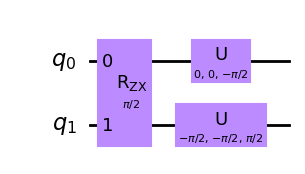

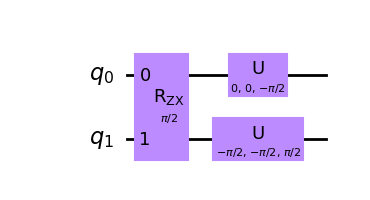

In [ ]:
qc = QuantumCircuit(2)
qc.cx(0, 1)
qc.swap(0, 1)
# transpile into CR gates
transpile(qc, basis_gates=["rzx", "u"], optimization_level=3).draw("mpl")

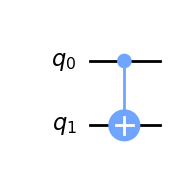

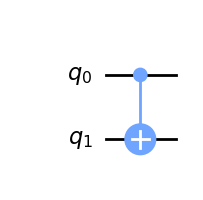

In [ ]:
qc = QuantumCircuit(2)
qc.cx(0, 1)
qc.draw("mpl")

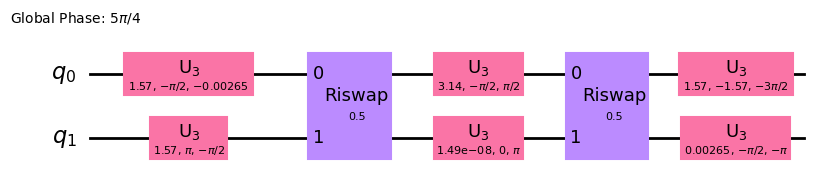

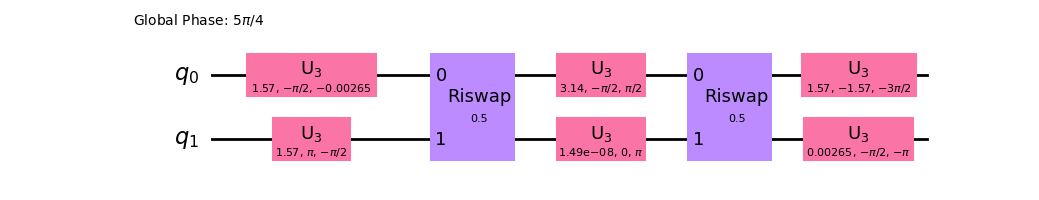

In [ ]:
from slam.utils.transpiler_pass.weyl_decompose import RootiSwapWeylDecomposition
from qiskit.transpiler import PassManager

pm = PassManager()
pm.append(RootiSwapWeylDecomposition())
qc = pm.run(qc)
qc.draw("mpl")

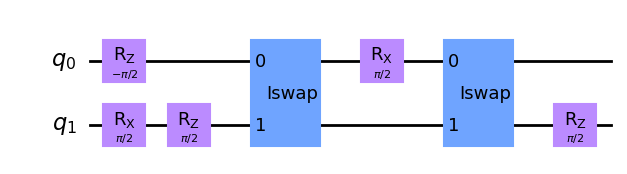

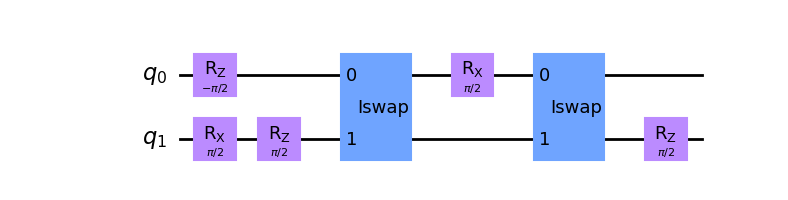

In [ ]:
qc1 = QuantumCircuit(2)
qc1.rx(np.pi / 2, 1)
qc1.rz(-np.pi / 2, 0)
qc1.rz(np.pi / 2, 1)
qc1.iswap(0, 1)
qc1.rx(np.pi / 2, 0)
qc1.iswap(0, 1)
qc1.rz(np.pi / 2, 1)
qc1.draw("mpl")

In [ ]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)
qc.cx(1, 0)
qc.h(1)
qc.cx(0, 1)
qc.tdg(1)

qc2 = QuantumCircuit(2)
qc2.s(0)
qc2.cx(1, 0)
qc2.sx(1)
qc2.sdg(0)
qc2.t(1)

qc3 = QuantumCircuit(2)
qc3.cx(1, 0)
qc3.cx(0, 1)

qc4 = QuantumCircuit(2)
qc4.cx(0, 1)
qc4.swap(0, 1)

c1 = c1c2c3(Operator(qc).data)
c2 = c1c2c3(Operator(qc2).data)
c3 = c1c2c3(Operator(qc3).data)
c4 = c1c2c3(Operator(qc4).data)
print(c1, c2, c3, c4)

(0.5, 0.0, 0.0) (0.5, 0.0, 0.0) (0.5, 0.5, 0.0) (0.5, 0.5, 0.0)


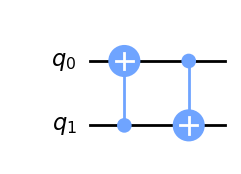

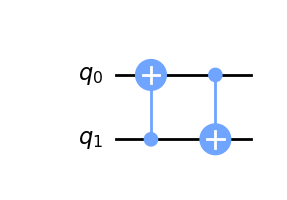

In [ ]:
qc3.draw("mpl")

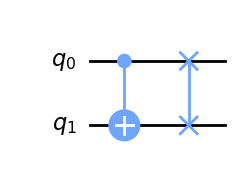

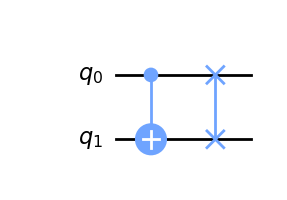

In [ ]:
qc4.draw("mpl")

In [ ]:
Operator(qc4).equiv(cx_replace)

True

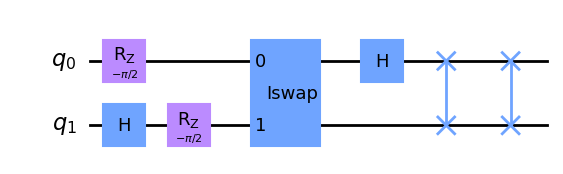

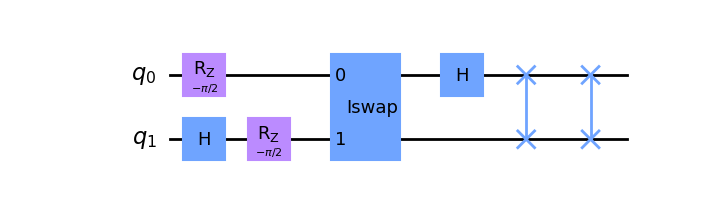

In [ ]:
from virtual_swap.cns_transform import cx_replace, iswap_replace

cx_replace.draw("mpl")

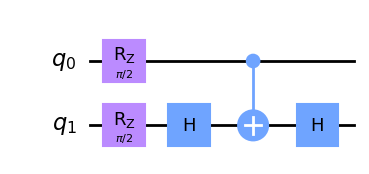

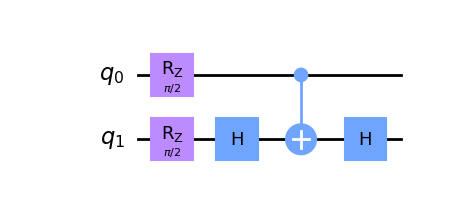

In [ ]:
iswap_replace.draw("mpl")

In [ ]:
Operator(qc3).equiv(qc4)

True

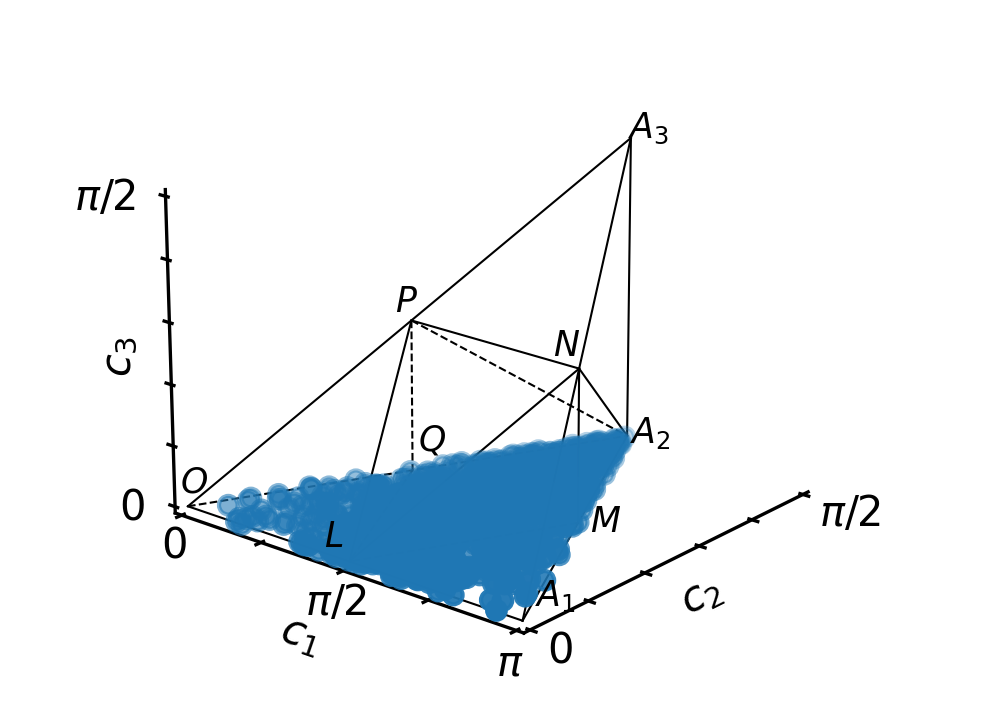

In [ ]:
# visualize weyl chamber coordinates
from weylchamber import WeylChamber

w = WeylChamber()
N = 1000
for _ in range(N):
    qc = QuantumCircuit(2)
    # random 1q
    qc.u(
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        0,
    )
    qc.u(
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        1,
    )
    # qc.crz(2 * np.pi * np.random.rand(), 0, 1)
    qc.cx(0, 1)

    # random 1q
    qc.u(
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        0,
    )
    qc.u(
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        1,
    )
    # qc.swap(0, 1)
    # qc.cx(0, 1)
    qc.iswap(0, 1)

    # random 1q
    qc.u(
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        0,
    )
    qc.u(
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        1,
    )

    qc.swap(0, 1)
    op = Operator(qc).data
    w.add_point(*c1c2c3(op))
w.plot()

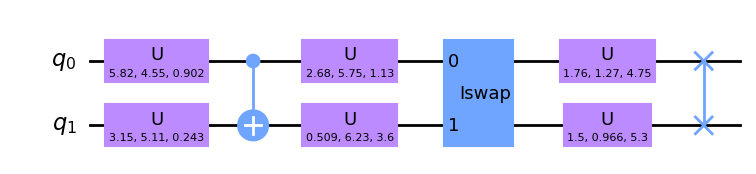

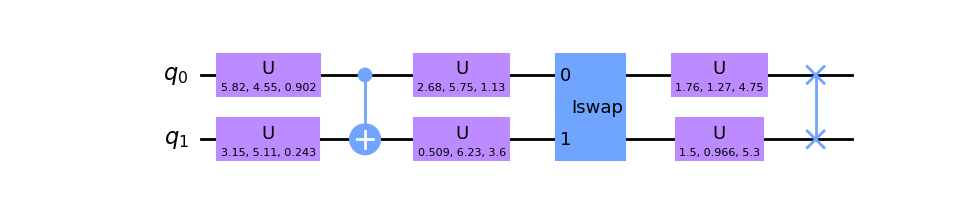

In [ ]:
qc.draw("mpl")

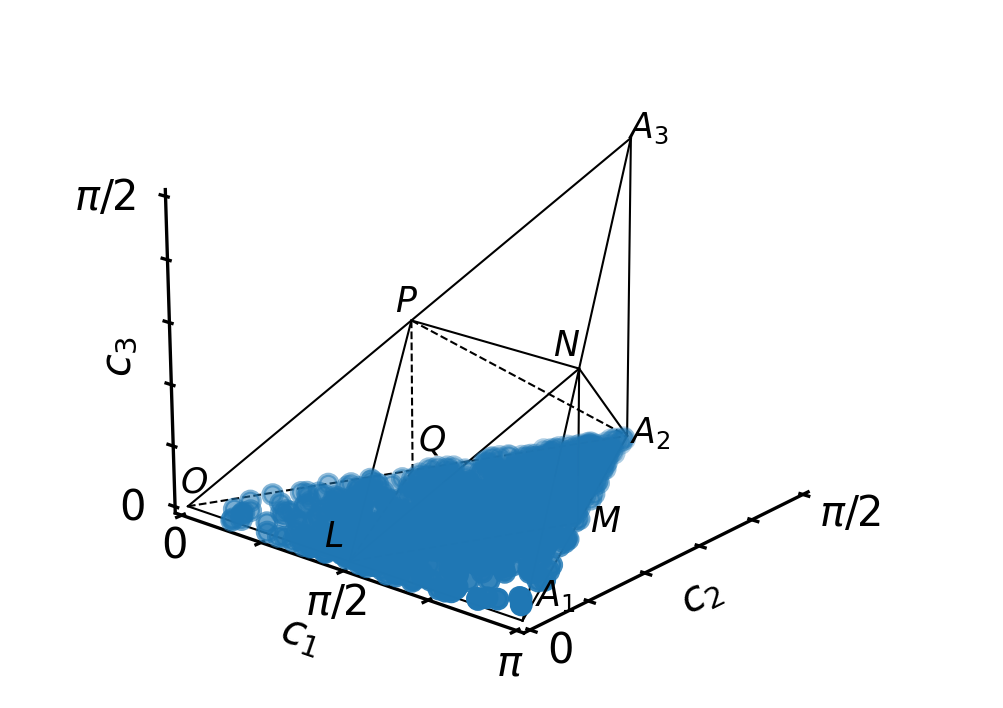

In [ ]:
# visualize weyl chamber coordinates
from qiskit import QuantumCircuit
from weylchamber import c1c2c3, WeylChamber
from qiskit.quantum_info import Operator
import numpy as np

w = WeylChamber()
N = 1000
for _ in range(N):
    qc = QuantumCircuit(2)
    # random 1q
    qc.u(
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        0,
    )
    qc.u(
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        1,
    )
    qc.cx(0, 1)

    # random 1q
    qc.u(
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        0,
    )
    qc.u(
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        1,
    )
    qc.iswap(0, 1)

    # random 1q
    qc.u(
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        0,
    )
    qc.u(
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        1,
    )
    qc.swap(0, 1)

    # random 1q
    qc.u(
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        0,
    )
    qc.u(
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        2 * np.pi * np.random.rand(),
        1,
    )
    op = Operator(qc).data
    w.add_point(*c1c2c3(op))
w.plot()

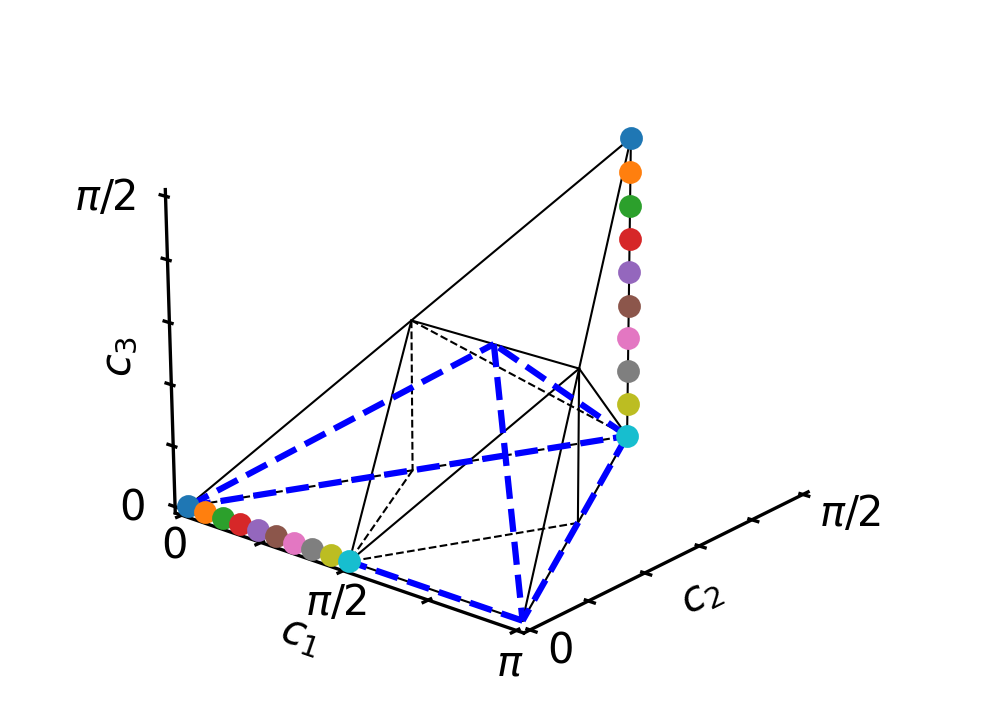

In [37]:
import matplotlib.pyplot as plt

w = WeylChamber()
# generate a color gradient
N = 9
color_gradient = [
    plt.cm.tab10(i / (N + 1)) for i in range(N + 1)
]  # using 'plasma' colormap here
w = WeylChamber()

# create two lists for the two types of operations
op1_list = []
op2_list = []

# iterate from I to CX (theta = 0 to np.pi)
for i in range(N + 1):
    qc = QuantumCircuit(2)
    qc.cp(np.pi * i / N, 0, 1)
    op1 = Operator(qc).data
    t = c1c2c3(op1)
    # force to use x < 1/2
    if t[0] > 0.5:
        t = (1 - t[0], t[1], t[2])
    op1_list.append((t, color_gradient[i]))
    qc.swap(0, 1)
    op2 = Operator(qc).data
    op2_list.append((c1c2c3(op2), color_gradient[i]))

# add the operations to the Weyl chamber
for coords, color in op1_list:
    w.scatter(*coords, color=color)
for coords, color in op2_list:
    w.scatter(*coords, color=color)

# define a region using line segments between the following points
# (0,0,0), (1/2, 1/2, 0); (0,0,0), (1,0,0); (1/2, 1/2, 0), (1,0,0); (0,0,0), (1/2, 1/4, 1/4)
lines = [
    [(0, 0, 0), (0.5, 0.5, 0)],
    [(0, 0, 0), (1, 0, 0)],
    [(0.5, 0.5, 0), (1, 0, 0)],
    [(0, 0, 0), (0.5, 0.25, 0.25)],
    [(0.5, 0.5, 0), (0.5, 0.25, 0.25)],
    [(0.5, 0.25, 0.25), (1, 0, 0)],
]
# draw the lines
w.labels = {}
w.plot()
for i in range(len(lines)):
    w._draw_line(
        w.ax, origin=lines[i][0], end=lines[i][1], color="blue", linestyle="--"
    )
w.fig.savefig("cphase_swap.svg", dpi=300)
# fig.savefig("cphase_swap.svg", dpi=300)

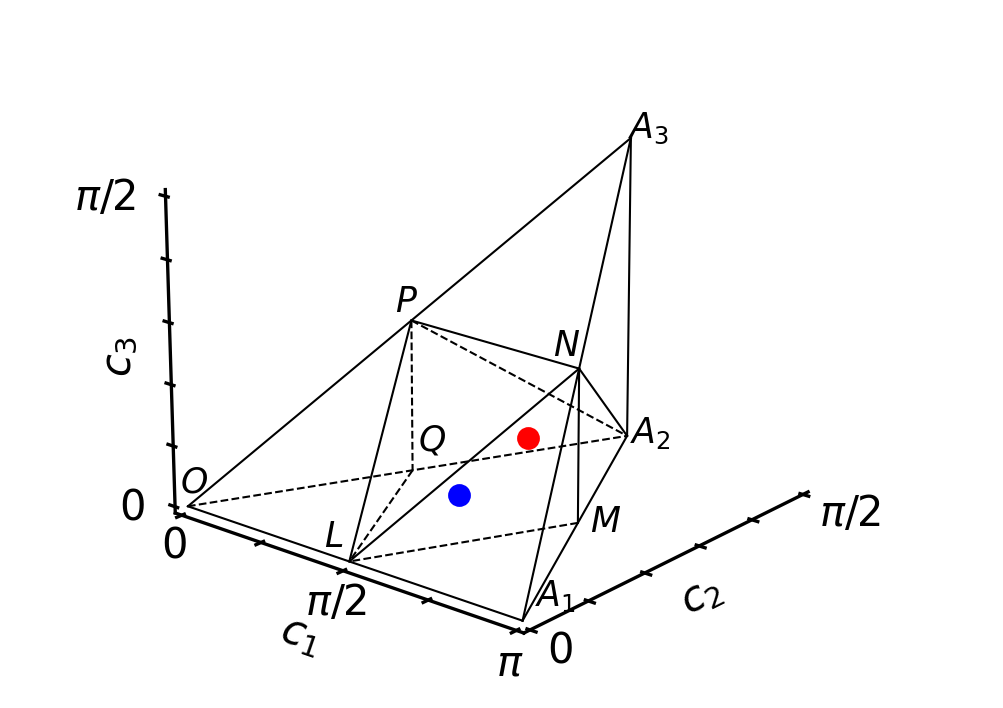

In [ ]:
w = WeylChamber()

# generate Haar random unitary
from qiskit.quantum_info import random_unitary

op = random_unitary(4).data
qc = QuantumCircuit(2)
qc.unitary(op, [0, 1])
op = Operator(qc).data
w.scatter(*c1c2c3(op), color="blue")
qc.swap(0, 1)
op2 = Operator(qc).data
w.scatter(*c1c2c3(op2), color="red")
w.plot()

In [ ]:
import numpy as np
from qiskit.quantum_info import random_unitary
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt
from matplotlib import cm

w = WeylChamber()


# Generate many random unitaries
N = 1000
coords_initial = []
coords_final = []
for _ in range(N):
    # Generate Haar random unitary
    op = random_unitary(4).data
    qc = QuantumCircuit(2)
    qc.unitary(op, [0, 1])
    op = Operator(qc).data
    coords_initial.append(c1c2c3(op))

    # Apply SWAP
    qc.swap(0, 1)
    op2 = Operator(qc).data
    coords_final.append(c1c2c3(op2))

# Convert to numpy arrays for easier handling
coords_initial = np.array(coords_initial)
coords_final = np.array(coords_final)

# Plot initial points with blue color
w.scatter(
    coords_initial[:, 0], coords_initial[:, 1], coords_initial[:, 2], color="blue"
)

# Plot final points with red color
w.scatter(coords_final[:, 0], coords_final[:, 1], coords_final[:, 2], color="red")

import matplotlib as mpl

# Create a color map with 256 colors
color_map = mpl.cm.get_cmap("viridis", 256)

# Generate colors from the color map
colors = color_map(np.linspace(0, 1, N))

# Plot trajectories
for i in range(N):
    w._draw_line(
        (coords_initial[i, 0], coords_initial[i, 1], coords_initial[i, 2]),
        (coords_final[i, 0], coords_final[i, 1], coords_final[i, 2]),
        color=colors[i],
    )

/tmp/ipykernel_7577/2101149099.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = mpl.cm.get_cmap("viridis", 256)


TypeError: _draw_line() missing 1 required positional argument: 'end'

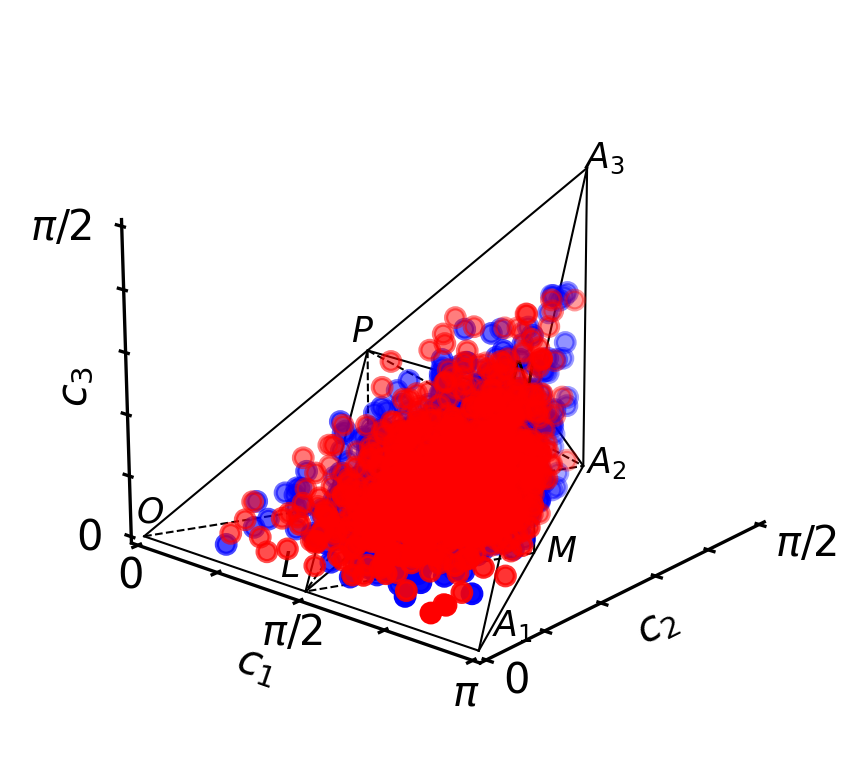

In [ ]:
w.plot()